# 3章 顧客の全体像を把握する１０本ノック

ここでは、スポーツジムの会員データを使って顧客の行動を分析していきます。  
これまでと同様にまずはデータを理解し、加工した後、顧客の行動データを分析していきましょう。  
ここでは、機械学習に向けての初期分析を行います。

### ノック21：データを読み込んで把握しよう
- use_log.csv : 会員のジム利用履歴
- customer_master.csv : 集計時点での会員データ
- class_master.csv : 会員のステータスデータ(オールタイム、デイタイムなど)
- campaign_master.csv : ユーザに付与されているキャンペーンデータ

In [49]:
import pandas as pd

use_log_df = pd.read_csv("use_log.csv")
use_log_df

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01
...,...,...,...
197423,L00000049209753,TS977703,2019-03-31
197424,L00000049209754,TS979550,2019-03-31
197425,L00000049209755,TS995299,2019-03-31
197426,L00000049209756,TS995853,2019-03-31


In [50]:
customer_master_df = pd.read_csv("customer_master.csv")
customer_master_df

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0
...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14 00:00:00,NaN,CA1,0
4188,HD246549,XXXXX,C01,F,2019-03-14 00:00:00,NaN,CA1,0
4189,GD037007,XXXXX,C03,M,2019-03-14 00:00:00,NaN,CA1,0
4190,OA953150,XXXXX,C01,M,2019-03-14 00:00:00,NaN,CA1,0


In [51]:
class_master_df = pd.read_csv("class_master.csv")
class_master_df

,class,class_name,price
0,C01,オールタイム,10500
1,C02,デイタイム,7500
2,C03,ナイト,6000


In [52]:
campaign_master_df = pd.read_csv("campaign_master.csv")
campaign_master_df

,campaign_id,campaign_name
0,CA1,通常
1,CA2,入会費半額
2,CA3,入会費無料


### 僕が思った方針メモ
まずは退会しているユーザが全体でどの程度かを見てみる。

次に退会したユーザに絞って、行動特性を見てみる。
ex. 月ごとの利用回数の推移、会員ステータス、キャンペーンの有無

そこから、退会しそうなユーザの特徴をなんとなく掴み、退会しそうなユーザ層を予測する。

### ノック22：顧客データを整形しよう

In [53]:
# customerにキャンペーンとステータスをmergeする
customer_master_df = pd.merge(customer_master_df, class_master_df, on='class', how='left')
customer_master_df = pd.merge(customer_master_df, campaign_master_df, on='campaign_id', how='left')
customer_master_df

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,ナイト,6000,通常
...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14 00:00:00,NaN,CA1,0,オールタイム,10500,通常
4188,HD246549,XXXXX,C01,F,2019-03-14 00:00:00,NaN,CA1,0,オールタイム,10500,通常
4189,GD037007,XXXXX,C03,M,2019-03-14 00:00:00,NaN,CA1,0,ナイト,6000,通常
4190,OA953150,XXXXX,C01,M,2019-03-14 00:00:00,NaN,CA1,0,オールタイム,10500,通常


In [54]:
# join後は、上手く結合できてないと欠損値が発生しているので、nanを見ておく
customer_master_df.isnull().sum() # 追加したデータに欠損がなければ一旦OK

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

### ノック23：顧客データの基礎集計をしよう

In [55]:
# まずは退会情報、会員ステータスの分布、キャンペーンの分布を見てみる
customer_master_df.groupby('is_deleted').count()['customer_id']

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

In [56]:
# 会員ステータス
customer_master_df.groupby('class_name').count()['customer_id']

class_name
オールタイム    2045
デイタイム     1019
ナイト       1128
Name: customer_id, dtype: int64

In [57]:
# キャンペーン
customer_master_df.groupby('campaign_name').count()['customer_id']

campaign_name
入会費半額     650
入会費無料     492
通常       3050
Name: customer_id, dtype: int64

In [58]:
# 性別
customer_master_df.groupby('gender').count()['customer_id']

gender
F    1983
M    2209
Name: customer_id, dtype: int64

### ノック24：最新顧客データの基礎集計をしよう
最新状態の顧客データを把握する。
まずは現在時点の在籍しているユーザを取得する。
また、退会のis_deletedが書き込まれるのにディレイが発生するので、end_dateで把握する。

In [59]:
customer_master_df['end_date'].isna()

0       True
1       True
2       True
3       True
4       True
        ... 
4187    True
4188    True
4189    True
4190    True
4191    True
Name: end_date, Length: 4192, dtype: bool

In [60]:
customer_master_df['end_date'] = pd.to_datetime(customer_master_df['end_date'])
latest_customer_master_df = customer_master_df.loc[(customer_master_df['end_date'] >= pd.to_datetime('20190331')) | (customer_master_df['end_date'].isna())]
latest_customer_master_df

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaT,CA1,0,オールタイム,10500,通常
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaT,CA1,0,オールタイム,10500,通常
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaT,CA1,0,オールタイム,10500,通常
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaT,CA1,0,オールタイム,10500,通常
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaT,CA1,0,ナイト,6000,通常
...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14 00:00:00,NaT,CA1,0,オールタイム,10500,通常
4188,HD246549,XXXXX,C01,F,2019-03-14 00:00:00,NaT,CA1,0,オールタイム,10500,通常
4189,GD037007,XXXXX,C03,M,2019-03-14 00:00:00,NaT,CA1,0,ナイト,6000,通常
4190,OA953150,XXXXX,C01,M,2019-03-14 00:00:00,NaT,CA1,0,オールタイム,10500,通常


In [61]:
# 最新時点で退会していないユーザは、退会日が存在していないか、最終月に退会申請があったユーザとなる
latest_customer_master_df['end_date'].unique()

array([                          'NaT', '2019-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [62]:
# 在籍しているユーザの各種属性を見てみる
latest_customer_master_df.groupby('class').count()['customer_id']

class
C01    1444
C02     696
C03     813
Name: customer_id, dtype: int64

In [63]:
latest_customer_master_df.groupby('gender').count()['customer_id']

gender
F    1400
M    1553
Name: customer_id, dtype: int64

In [64]:
latest_customer_master_df.groupby('campaign_name').count()['customer_id']

campaign_name
入会費半額     311
入会費無料     242
通常       2400
Name: customer_id, dtype: int64

### ノック25：利用履歴データを集計しよう
在籍ユーザと全体で基本データから有意な差分が発見できなかったので、利用データを見てみる。

In [65]:
use_log_df

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01
...,...,...,...
197423,L00000049209753,TS977703,2019-03-31
197424,L00000049209754,TS979550,2019-03-31
197425,L00000049209755,TS995299,2019-03-31
197426,L00000049209756,TS995853,2019-03-31


In [66]:
use_log_df['usedate'] = pd.to_datetime(use_log_df['usedate'])
use_log_df['use_month'] = use_log_df['usedate'].dt.strftime('%Y%m')
use_month_df = use_log_df.groupby(['use_month', 'customer_id'], as_index=False).count() # 月ごとの利用履歴をユーザごとにまとめる
use_month_df.rename(columns={"log_id":"count"}, inplace=True) #カラム名を変更する。inplace無いと更新されない
del use_month_df["usedate"]
use_month_df

,use_month,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7
...,...,...,...
36837,201903,TS995853,8
36838,201903,TS998593,8
36839,201903,TS999079,3
36840,201903,TS999231,6


In [67]:
# 集計した月ごとデータを元に統計情報を見てみる
use_month_customer = use_month_df.groupby('customer_id').agg(["mean", "median", "max", "min"])['count']
use_month_customer = use_month_customer.reset_index(drop=False)
use_month_customer

# ユーザごとの利用回数統計

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4
...,...,...,...,...,...
4187,TS995853,9.500000,9.5,11,8
4188,TS998593,8.142857,8.0,9,7
4189,TS999079,4.916667,5.5,9,2
4190,TS999231,4.666667,5.0,8,1


### ノック26：利用履歴データから定期利用フラグを作成しよう

利用データから定期的な利用があるかを判別する。同じ曜日にきているかで判断する

In [68]:
use_log_df['weekday'] = use_log_df['usedate'].dt.weekday # 時間を曜日に変換
# ユーザがその月に同じ曜日に利用したデータ.log_idをカウントしている
use_log_week_df = use_log_df.groupby(['customer_id', 'use_month', 'weekday'], as_index=False).count()[['customer_id', 'use_month', 'weekday', 'log_id']]
use_log_week_df.rename(columns={'log_id':'count'}, inplace=True)
use_log_week_df

,customer_id,use_month,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1
...,...,...,...,...
93328,TS999855,201901,1,1
93329,TS999855,201901,5,4
93330,TS999855,201901,6,1
93331,TS999855,201902,5,4


In [69]:
# 上記データを元に月ごとに同じ曜日に利用している回数が4以上のユーザにフラグを立てる

# ユーザごとの一月に同じ曜日に利用した最大回数
use_log_week_df = use_log_week_df.groupby('customer_id', as_index=False).max()[['customer_id', 'count']]
use_log_week_df['routine_flg'] = 0 # 定期利用フラグを初期化
use_log_week_df['routine_flg'] = use_log_week_df['routine_flg'].where(use_log_week_df['count']<4, 1)
use_log_week_df

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1
...,...,...,...
4187,TS995853,5,1
4188,TS998593,5,1
4189,TS999079,5,1
4190,TS999231,5,1


### ノック27：顧客データと利用履歴データを結合しよう

作成した２つのデータセットを結合する。

In [70]:
# use_log_week_dfとuse_month_customerを結合する
customer_master_df = pd.merge(customer_master_df, use_month_customer, on='customer_id', how='left')
customer_master_df = pd.merge(customer_master_df, use_log_week_df, on='customer_id', how='left')
customer_master_df

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,count,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,4,1
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,5,1
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,5,1
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,5,1
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14 00:00:00,NaT,CA1,0,オールタイム,10500,通常,8.000000,8.0,8,8,3,0
4188,HD246549,XXXXX,C01,F,2019-03-14 00:00:00,NaT,CA1,0,オールタイム,10500,通常,10.000000,10.0,10,10,3,0
4189,GD037007,XXXXX,C03,M,2019-03-14 00:00:00,NaT,CA1,0,ナイト,6000,通常,8.000000,8.0,8,8,2,0
4190,OA953150,XXXXX,C01,M,2019-03-14 00:00:00,NaT,CA1,0,オールタイム,10500,通常,11.000000,11.0,11,11,3,0


In [71]:
customer_master_df.isnull().all()

customer_id      False
name             False
class            False
gender           False
start_date       False
end_date         False
campaign_id      False
is_deleted       False
class_name       False
price            False
campaign_name    False
mean             False
median           False
max              False
min              False
count            False
routine_flg      False
dtype: bool

### ノック28：会員期間を計算しよう
ユーザごとに在籍している期間を計算してみる。
退会の有無にかかわらず、現時点での在籍期間にする。

計算日時点での日付は2019年3月31日。

In [78]:
from dateutil.relativedelta import relativedelta # 月単位の計算はこれを使う
customer_master_df['calc_date'] = customer_master_df['end_date']
# 退会日が無いユーザのために、一ヶ月後を指定する
customer_master_df['calc_date'] = customer_master_df['calc_date'].fillna(pd.to_datetime('20190430'))
customer_master_df['start_date'] = pd.to_datetime(customer_master_df['start_date'])
customer_master_df['membership_period'] = 0 #会員期間を初期化
customer_master_df

for i in range(len(customer_master_df)):
    delta = relativedelta(customer_master_df['calc_date'].iloc[i], customer_master_df['start_date'].iloc[i])
    customer_master_df['membership_period'].iloc[i] = delta.years*12 + delta.months
customer_master_df

/home/mike/www/privates/100_knock/python_data_analyze/.venv/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,count,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,4,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,5,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,5,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,5,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,5,1,2019-04-30,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14,NaT,CA1,0,オールタイム,10500,通常,8.000000,8.0,8,8,3,0,2019-04-30,1
4188,HD246549,XXXXX,C01,F,2019-03-14,NaT,CA1,0,オールタイム,10500,通常,10.000000,10.0,10,10,3,0,2019-04-30,1
4189,GD037007,XXXXX,C03,M,2019-03-14,NaT,CA1,0,ナイト,6000,通常,8.000000,8.0,8,8,2,0,2019-04-30,1
4190,OA953150,XXXXX,C01,M,2019-03-14,NaT,CA1,0,オールタイム,10500,通常,11.000000,11.0,11,11,3,0,2019-04-30,1


### ノック29：顧客行動の各種統計量を把握しよう

In [79]:
customer_master_df.groupby('routine_flg').count()['customer_id']

routine_flg
0     779
1    3413
Name: customer_id, dtype: int64

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

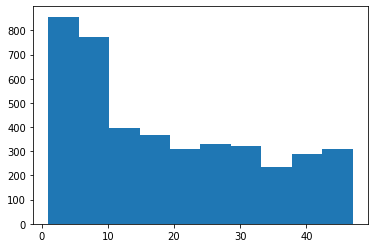

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(customer_master_df['membership_period'])

上記からジムはだいたい10ヶ月のところに継続の壁があることがわかる。

### ノック30：退会ユーザーと継続ユーザーの違いを把握しよう

In [82]:
customer_end = customer_master_df[customer_master_df['is_deleted'] == 0]
customer_end.describe()

,is_deleted,price,mean,median,max,min,count,routine_flg,membership_period
count,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000
mean,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,4.865588,0.984166,23.970443
std,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.406154,0.124855,13.746761
min,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,2.000000,0.000000,1.000000
25%,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,5.000000,1.000000,12.000000
50%,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,5.000000,1.000000,24.000000
75%,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,5.000000,1.000000,35.000000
max,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,5.000000,1.000000,47.000000


In [83]:
customer_stay = customer_master_df[customer_master_df['is_deleted'] == 1]
customer_stay.describe()

,is_deleted,price,mean,median,max,min,count,routine_flg,membership_period
count,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,3.215556,0.456296,8.026667
std,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,1.217087,0.498271,5.033692
min,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,2.000000,0.000000,4.000000
50%,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,3.000000,0.000000,7.000000
75%,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,4.000000,1.000000,11.000000
max,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,5.000000,1.000000,23.000000


In [ ]:
# 上記から退会ユーザと継続ユーザにはゆう